In [4]:
# Import required libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import ResNet18_Weights
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

In [5]:
# Main script to initiate the training process
if __name__ == "__main__":
    # Download dataset using kagglehub and train the model
    path = kagglehub.dataset_download('koinguyn/chess-detection')
    data_path = f"{path}"

Resuming download from 99614720 bytes (88138256 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/koinguyn/chess-detection?dataset_version_number=1 (99614720/187752976) bytes left.


100%|██████████| 179M/179M [00:05<00:00, 17.0MB/s] 

Extracting files...


In [10]:
batch_size = 64
num_epochs = 100
learning_rate = 0.001
model_save_path = "chess_model.pth"
patience = 15

"""
    Args:
    data_path (str): Path to the dataset directory.
    epochs (int): Number of training epochs.
    batch_size (int): Size of each training batch.
    learning_rate (float): Learning rate for the optimizer.
    model_save_path (str): Path to save the best model.
    patience (int): Number of epochs to wait for improvement before early stopping.
"""

'\n    Args:\n    data_path (str): Path to the dataset directory.\n    epochs (int): Number of training epochs.\n    batch_size (int): Size of each training batch.\n    learning_rate (float): Learning rate for the optimizer.\n    model_save_path (str): Path to save the best model.\n    patience (int): Number of epochs to wait for improvement before early stopping.\n'

In [11]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    """
    Plots the confusion matrix using seaborn heatmap.
    
    Args:
    cm (array): Confusion matrix.
    class_names (list): List of class names for labels.
    """
    plt.figure(figsize=(10, 7))  # Set plot size
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [12]:
# Check if GPU is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transformations for preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 (input size for ResNet18)
    transforms.RandomRotation(15),  # Randomly rotate images by up to 15 degrees
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly adjust color properties
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize pixel values
])

In [ ]:
# Load dataset from the specified directory
dataset = datasets.ImageFolder(os.path.join(data_path, "train"), transform=transform)
num_classes = len(dataset.classes)  # Get the number of classes

# Print class names and their indices
print(f"Classes: {dataset.classes}")
print(f"Class-to-Index Mapping: {dataset.class_to_idx}")

# Split dataset into training and validation sets (80-20 split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader objects for batch loading
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 224x224x3 image tensor)
        self.conv1 = nn.Conv2d(3, 32, 3, padding=0)
        # BatchNorm after conv1
        self.bn1 = nn.BatchNorm2d(32)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)


        # convolutional layer (sees 111x111x32 tensor)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # BatchNorm after conv2
        self.bn2 = nn.BatchNorm2d(64)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)


        # convolutional layer (sees 59x59x64 tensor)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=2)
        # BatchNorm after conv3
        self.bn3 = nn.BatchNorm2d(128)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)


        # convolutional layer (sees 31x31x128 tensor)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=2)
        # BatchNorm after conv4
        self.bn4 = nn.BatchNorm2d(256)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)


        # linear layer (256 * 15 * 15 -> 512)
        self.fc1 = nn.Linear(256 * 15 * 15, 512)
        self.fc1_bn = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.25)
        # linear layer (512 -> 256)
        self.fc2 = nn.Linear(512, 256)
        self.fc2_bn = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.25)
        # linear layer (256 -> 6)
        self.fc3 = nn.Linear(256, 6)


    def forward(self, x):
        # Convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # Flattening of result for fully connected (linear) layers
        x = torch.flatten(x, 1)
        # 1st fully connected layer
        x = self.dropout1(F.relu(self.fc1_bn(self.fc1(x))))
        # 2nd fully connected layer
        x = self.dropout2(F.relu(self.fc2_bn(self.fc2(x))))
        # 3rd fully connected layer
        x = F.softmax(self.fc3(x), dim=1)
        return x


model = Net.to(device)  # Move model to the appropriate device (GPU/CPU)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Learning rate scheduler to reduce learning rate when validation loss plateaus
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

Classes: ['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']
Class-to-Index Mapping: {'Bishop': 0, 'King': 1, 'Knight': 2, 'Pawn': 3, 'Queen': 4, 'Rook': 5}


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [23]:
# Function to train the model
def train_model(epochs, batch_size, learning_rate, model_save_path, patience):
    # Variables to track the best validation loss and early stopping
    best_val_loss = float('inf')
    patience_counter = 0

    # Lists to store accuracies for plotting
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training step
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Reset gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)  # Get predicted labels
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        # Compute training accuracy
        train_acc = correct_train / total_train
        train_accuracies.append(train_acc)

        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        all_preds = []
        all_labels = []

        # Validation step
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

                # Collect predictions and true labels for evaluation
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Compute validation loss and accuracy
        val_loss /= len(val_loader)
        val_acc = correct_val / total_val
        val_accuracies.append(val_acc)

        # Print metrics for the current epoch
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_acc * 100:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc * 100:.2f}%")

        scheduler.step(val_loss)  # Adjust learning rate based on validation loss

        # Save the model if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)  # Save model
            print(f"Model saved to {model_save_path}")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epoch(s).")

        # Stop training if validation loss does not improve for 'patience' epochs
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

    # Compute and display confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)
    plot_confusion_matrix(cm, dataset.classes)

    # Display classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=dataset.classes))

    # Plot training and validation accuracies over epochs
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.show()

    print("Training complete!")

Epoch 1/15, Train Loss: 0.2373, Train Accuracy: 92.49%, Val Loss: 0.4619, Val Accuracy: 82.86%
Model saved to chess_model.pth
Epoch 2/15, Train Loss: 0.1669, Train Accuracy: 94.28%, Val Loss: 0.2017, Val Accuracy: 92.57%
Model saved to chess_model.pth
Epoch 3/15, Train Loss: 0.1066, Train Accuracy: 96.25%, Val Loss: 0.3940, Val Accuracy: 89.29%
No improvement for 1 epoch(s).
Epoch 4/15, Train Loss: 0.1054, Train Accuracy: 96.39%, Val Loss: 0.1294, Val Accuracy: 96.29%
Model saved to chess_model.pth
Epoch 5/15, Train Loss: 0.0902, Train Accuracy: 96.82%, Val Loss: 0.2585, Val Accuracy: 92.00%
No improvement for 1 epoch(s).
Epoch 6/15, Train Loss: 0.1016, Train Accuracy: 97.00%, Val Loss: 0.3242, Val Accuracy: 92.29%
No improvement for 2 epoch(s).
Epoch 7/15, Train Loss: 0.0960, Train Accuracy: 96.75%, Val Loss: 0.3429, Val Accuracy: 89.43%
No improvement for 3 epoch(s).
Epoch 8/15, Train Loss: 0.0875, Train Accuracy: 96.85%, Val Loss: 0.1457, Val Accuracy: 95.71%
No improvement for 4 ep

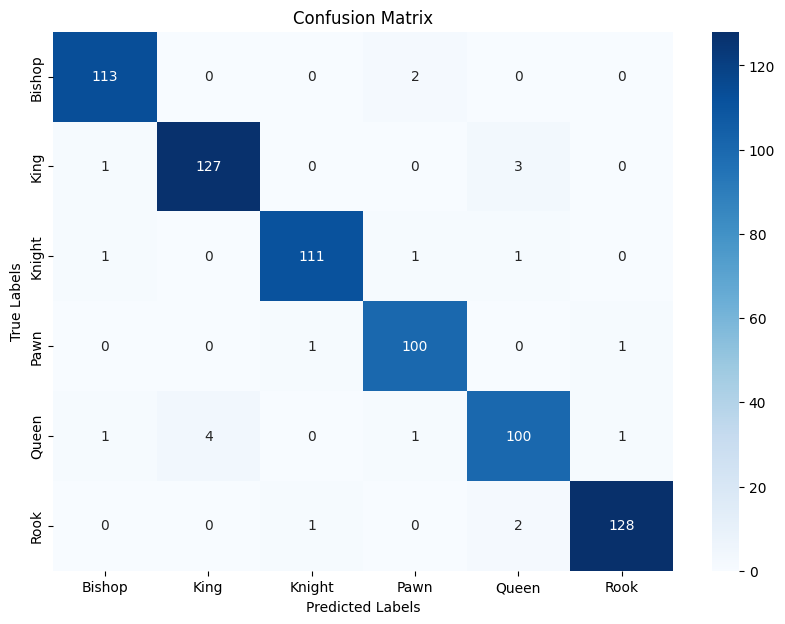

Classification Report:
              precision    recall  f1-score   support

      Bishop       0.97      0.98      0.98       115
        King       0.97      0.97      0.97       131
      Knight       0.98      0.97      0.98       114
        Pawn       0.96      0.98      0.97       102
       Queen       0.94      0.93      0.94       107
        Rook       0.98      0.98      0.98       131

    accuracy                           0.97       700
   macro avg       0.97      0.97      0.97       700
weighted avg       0.97      0.97      0.97       700



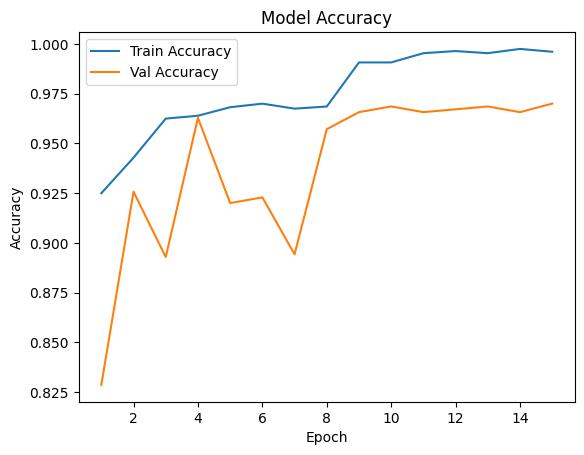

Training complete!


In [24]:
train_model(num_epochs, batch_size, learning_rate, model_save_path, patience)